# Documentation for CC + IDS multi-dimensional trellis classes
=============================================================================================================

## Dependencies

These are what I used, and typically everything should run with higher versions of the following modules.

- Python 3.7.6
- Numpy: 1.18.1
- Pandas: 1.0.1 (Needed to display variables conveniently)
- Seaborn: 0.10.0 (Can ignore this module or comment it out wherever used, just used for aesthetics)
- Numba: 0.48.0 (Most of the computation intensive functions have been compiled with numba)
- Tqdm: 4.42.1 (Used for progress bars)
- Matplotlib: 3.1.3 
- Scipy: 1.4.1
- Labellines (https://github.com/cphyc/matplotlib-label-lines)


## Importing essential modules

In [128]:
from helper_functions import *
import pandas as pd
import numpy as np
from scipy.stats import mode

from conv_code import *
from coded_ids_multiD import *
from bma import *

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Building the conv code

We will now build the convolutional code and the associated trellis. This trellis will be used as input to the IDS channel, which constructs a larger trellis on top of this (kind of does a composition operation by expanding the state-space to include the channel state information).

## 1.a. Define the finite-state machine corresponding to the convolutional code (CC)

- We first build a rate 1/2 code over $GF(4)$, where '2' refers to $\alpha$ and '3' refers to $\alpha^2$.
- The following example encoder has a memory of 2, i.e., the outputs are of the form $y_t = ax_t+bx_{t-1}+cx_{t-2}$. Specifically, for each input $x_t$ we output the following 2 symbols $x_t+x_{t-1}+x_{t-2}$ and $x_t+\alpha x_{t-1}+x_{t-2}$.

In [2]:
cc = conv_code()                 # instantiate CC object
G = np.array([[1,1,1],[1,2,1]])  # generator sequences (quaternary)
cc.quar_cc(G)                    # build the FSM (no time-expansion)

In [19]:
print(cc.states) # display encoder states

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [3 0]
 [3 1]
 [3 2]
 [3 3]]


In [20]:
cc.edges # display edges as pandas dataframe

,from_state,to_state,in_symb,out_symb
0,"[0, 0]","[0, 0]",0,"[0, 0]"
1,"[0, 0]","[1, 0]",1,"[1, 1]"
2,"[0, 0]","[2, 0]",2,"[2, 2]"
3,"[0, 0]","[3, 0]",3,"[3, 3]"
4,"[0, 1]","[0, 0]",0,"[1, 1]"
...,...,...,...,...
59,"[3, 2]","[3, 3]",3,"[2, 0]"
60,"[3, 3]","[0, 3]",0,"[0, 2]"
61,"[3, 3]","[1, 3]",1,"[1, 3]"
62,"[3, 3]","[2, 3]",2,"[2, 0]"


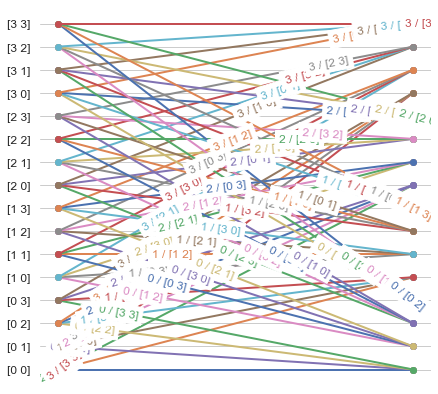

In [21]:
cc.draw_fsm(figsize = (7,7)) # draw the FSM (input/outputs displayed next to edges)

## 1.b. Construct time-expanded trellis

In [22]:
in_len = 10               # length of input
cc.make_trellis(in_len)   # make trellis edges
cc.make_encoder()         # make encoder "lookup" to facilitate encoding     

Making encoder lookup table: 100%|█████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.99it/s]


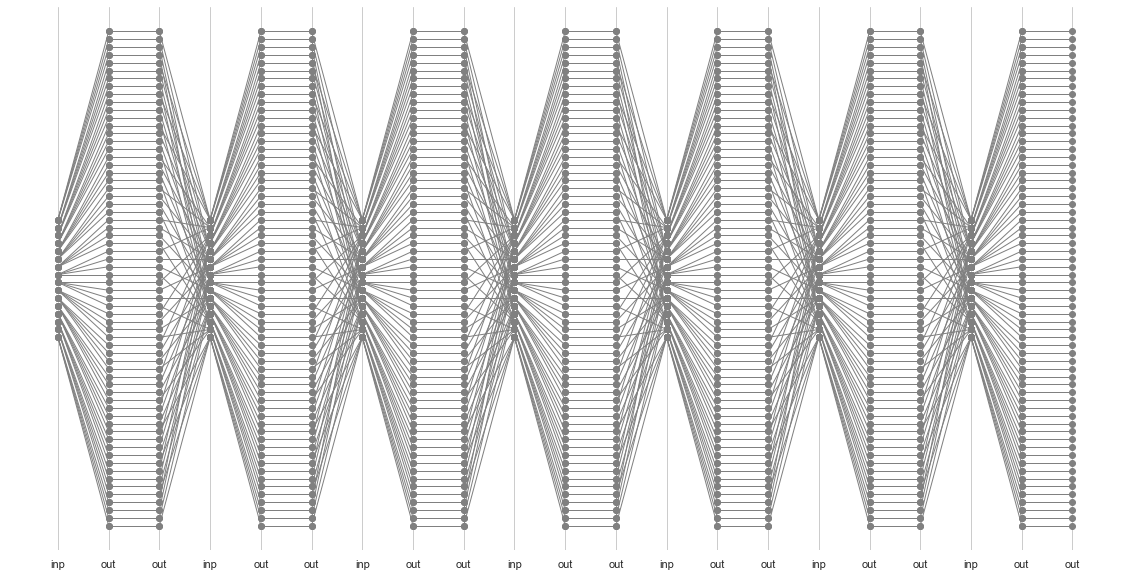

In [23]:
cc.draw_trellis(stages=[0,20],figsize = (20,10))  # draw the first 20 stages of the time expanded trellis

Let us try to understand the above trellis. The way we model the trellis is as follows:

- At the very first stage (labelled as "inp") the encoder is in the state [0,0] -- this is also the state of the trellis at this stage. Now it receives, an input symbol (only the stages labeled "inp" receive input). Say it receives '1'. 
- In the next stage, the encoder transits to the state [1,0] and should output 2 symbols '1' and '1' from the code design.
- However, instead of emitting both the outputs in one stage, we split this into 2 stages, one where the trellis emits the symbol '1' and the next where it emits '1' again -- this is the reason there are 2 "out" stages after the "inp" stage, one corresponding to each output.
- So, in the second stage, the encoder transits to state [1,0], but the trellis also tracks the "on-deck input" and "on-deck codeword" and expands the state-space accordingly.
- In the third stage, the encoder and the on-deck input don't change, while the on-deck codeword changes.

Let us now display the edges and make sense of how the state-space is modeled.

In [24]:
# First a function to display tables side-by-side

from IPython.core.display import HTML
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [25]:
multi_table([cc.trellis_edges[0],cc.trellis_edges[1],cc.trellis_edges[2]]) # display edges at stages 0,1,2 side-by-side

,from_state,to_state,weight
0,"[0, 0]","[0, 0, 0, 0]",0.25
1,"[0, 0]","[1, 0, 1, 1]",0.25
2,"[0, 0]","[2, 0, 2, 2]",0.25
3,"[0, 0]","[3, 0, 3, 3]",0.25
4,"[0, 1]","[0, 0, 0, 1]",0.25
...,...,...,...
59,"[3, 2]","[3, 3, 3, 2]",0.25
60,"[3, 3]","[0, 3, 0, 0]",0.25
61,"[3, 3]","[1, 3, 1, 1]",0.25
62,"[3, 3]","[2, 3, 2, 2]",0.25


- Table 1 (edges from stage 0): **from_state** -- [enc curr state], **to_state** -- [enc next state, input, output1], **weight** -- Pr(input)
- Table 2 (edges from stage 1): **from_state** -- [enc next state, input, output1], **to_state** -- [enc next state, input, output2]
- Table 3 (edges from stage 2): **from_state** -- [enc next state, input, output2], **to_state** -- [enc next state]

This might seem unnecessarily complicated at first, but the idea behind using this kind of a time-expanded single-output-per-stage model is the following:

- The IDS channel  operates on each symbol independently, so we must operate on one output symbol at a time.
- We construct the IDS trellis as follows: we expand each "out" stage in the above trellis $K+1$ times, where $K$ is the number of traces. This way, we can model the error events in each trace sequentially, one symbol at a time. We include an extra "dummy" stage for convenience of programming -- the extra stage is where we change the "on-deck" codeword symbol. We will revisit this in detail later in this notebook.

## 1.c. Encoding

In [26]:
in_seq = np.random.choice(4,size = in_len)  # generate a random 10 length quaternary sequence
cc.encode(in_seq)                           # encode and display encoded sequence

array([3, 3, 1, 3, 3, 2, 1, 0, 0, 3, 0, 2, 1, 0, 3, 3, 1, 2, 1, 1])

## 1.d. Puncturing, coset shift etc.

Recall that our code is a rate 1/2 code, mapping an input of size 10 to a codeword of size 20. Here we will puncture it so that there are only 5 redundant symbols instead of 10. We will also add a random coset shift to the code.

In [27]:
cc.puncture(redundancy=5)        # puncture so that only 5 redundant symbols remain
cc.add_coset()                   # add a random coset vector to the code
cc.make_encoder()                # make encoder lookup again for the updated trellis

Making encoder lookup table: 100%|█████████████████████████████████████████████████████| 25/25 [00:00<00:00, 77.79it/s]


Notice how the trellis changes once it is punctured.

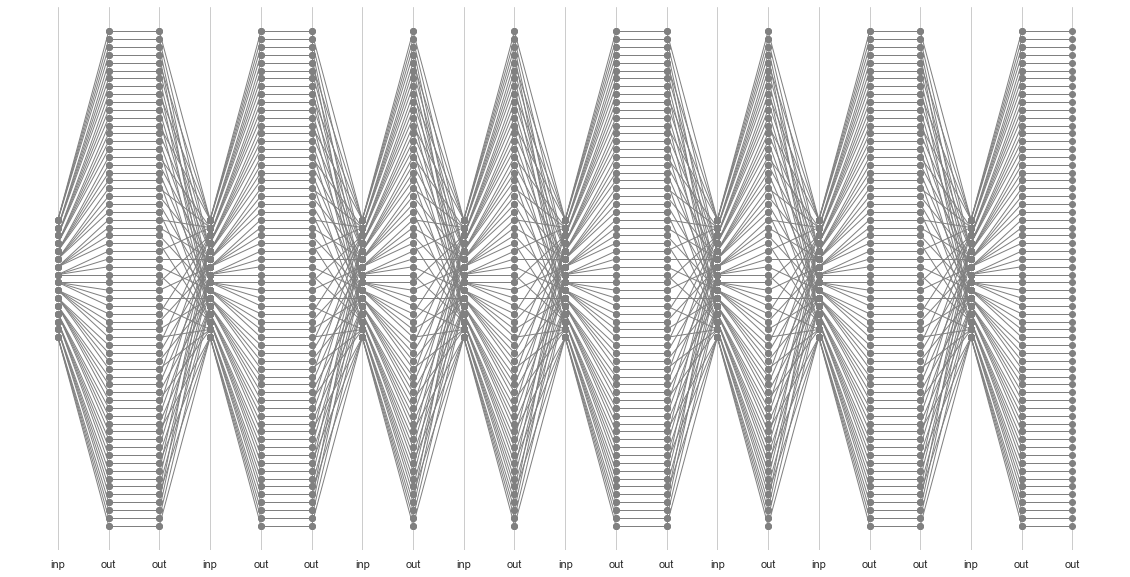

In [28]:
cc.draw_trellis(stages=[0,20],figsize = (20,10))  # draw the first 20 stages of the time expanded trellis

In [29]:
cc.encode(in_seq)  # encode same input sequence and display

array([1, 1, 0, 3, 1, 1, 2, 1, 1, 2, 3, 0, 0, 3, 3], dtype=int32)

Alternatively we could choose our coset vector.

In [30]:
coset_vector = np.random.choice(4,size = 15)
cc.add_coset(coset_vector)       # add the given coset vector
cc.make_encoder()                # make encoder lookup again for the updated trellis

Making encoder lookup table: 100%|█████████████████████████████████████████████████████| 25/25 [00:00<00:00, 73.52it/s]


# 2. Constructing IDS + code trellis

We now construct the trellis which describes the input-output distribution when the encoded sequence is passed through multiple parallel IDS channels. This builds on top of the code trellis already described.

## 2.a. Defining a simple code

Since the multi-dimensional IDS trellis is massive, we will now use a very simple code, for visualization. We build a simple rate 1/2 code, where the first output symbol is the same as the input symbol and the second output is $\alpha$ times the input symbol.

In [129]:
cc = conv_code()                 # instantiate CC object
G = np.array([[1],[1]])          # generator sequences (quaternary)
cc.quar_cc(G)                    # build the FSM (no time-expansion)
in_len = 4                      # length of input
cc.make_trellis(in_len)          # make trellis edges
# cc.puncture(redundancy=)        # puncture so that only 5 redundant symbols remain
cc.add_coset()                   # add a random coset vector to the code
cc.make_encoder()                # make encoder lookup again for the updated trellis

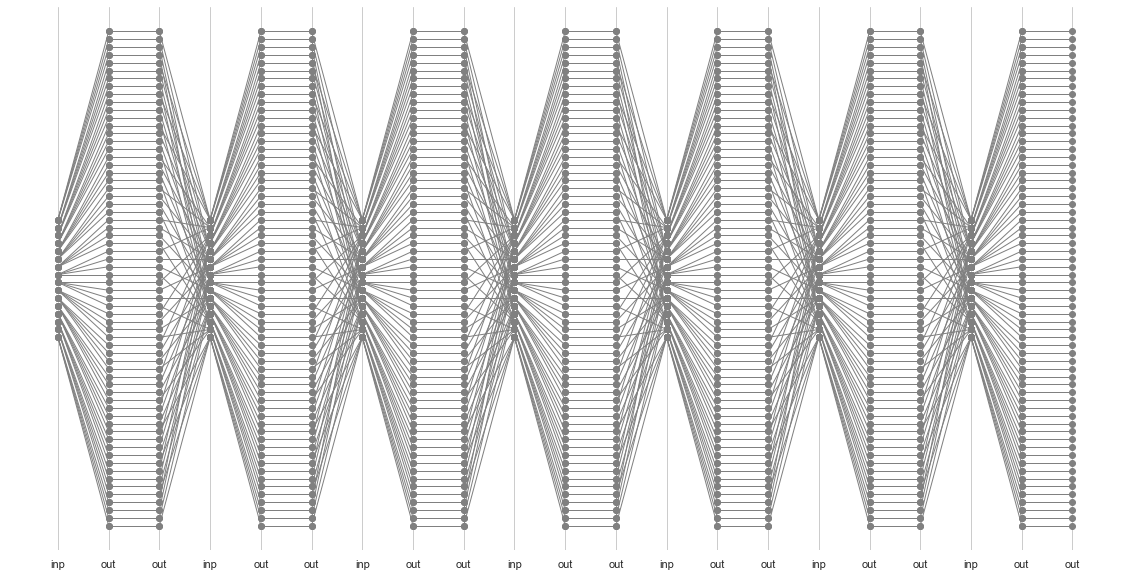

In [28]:
cc.draw_trellis(stages=[0,20],figsize = (20,10))  # draw the first 20 stages of the time expanded trellis

## 2.b. Building IDS trellis and visualization

In [130]:
A_in = 4                                  # Size of input alphabet
A_cw = 4                                  # Size of codeword alphabet
code_trellis_states = cc.trellis_states   # code trellis states
code_trellis_edges = cc.trellis_edges     # code trellis edges
code_time_type = cc.time_type             # code time type ("inp" stage or "out" stage)

num_traces = 1                           # number of traces for multiD trellis
p_del = 0.02                             # channel parameters
p_sub = 0.02
p_ins = 0.02

max_drift = 2                             # set drift range (drift = output pointer - input pointer)

cc_ids_object = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
                 num_traces, p_del, p_sub, p_ins, max_drift, input_prior = None)

Let us draw the first 10 stages of the trellis to see what it looks like. This might take a minute or two.

**Note**: Use the following cell ONLY when the state space is small, otherwise you might run into memory overflow and it takes very long to run.

Drawing trellis.: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.16it/s]


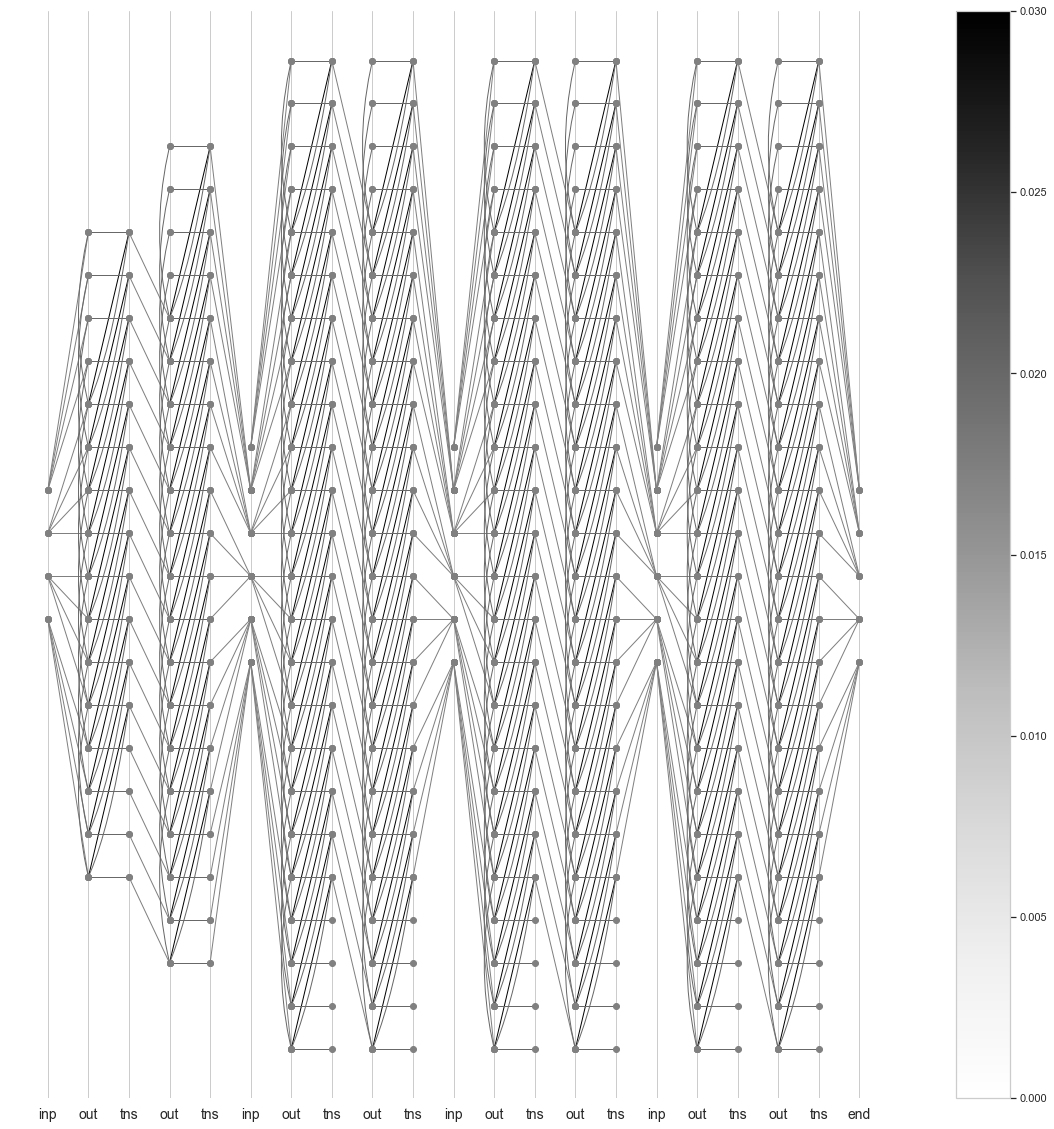

In [133]:
cc_ids_object.make_edges_dataframe()     # Collect edge information in a dataframe
"""
- Draw first 10 stages of trellis
- Uniformly colorcode the edges such that edges of weight 0 are white and edges
  having a weight >= 0.03 are black.
"""
cc_ids_object.draw_trellis(stages = [0,20], figsize = (20,20), fontsize = 14,edge_range=[0.0,0.03])

Again as in the CC trellis, we notice that the stages are marked "inp", "out", and in addition "tns" which refers to transition stages (dummy stages used for programming convenience).

From each state at an "out" stage, there are 4 different types of outgoing edges corresponding to the following events:
- replication: straight diagonal edges to the next stage
- substitution: curved diagonal edges to the next stage
- insertion: curved edges to a different state in the same stage
- deletion: straight horizontal edges to the next stage

The trellis is understood as follows:

- At the start (stage 0), the trellis state is $[p_1=0, p_2=0,enc\ state=[0,0]]$, where $p_1$ is the output pointer for the first trace and so forth, and $enc\ state$ is the current state of the encoder trellis (which is used to instantiate the IDS trellis object).
- It then receives an input symbol 'a' and transits to the state 
$[p_1=0, p_2=0, enc\ state=[a,0],ODIS=a,ODCS = a]$, where $ODIS$ refers to the on-deck input symbol and $ODCS$ refers to the on-deck codeword symbol. This corresponds to the first output symbol of the encoder.
- Now the edges from stage 1 model what happens to the first output symbol in the first trace. For example, if there was a substitution then a substitution edge (curved diagonal edges) might take it to the state $[p_1=1, p_2=0, enc\ state=[a,0],ODIS=a,ODCS = a]$ at stage 2.
- Next we similarly model what happens to the first output symbol in the second trace. For example, there could be an insertion, and then a replication in which case the trellis transits to a state in the same stage first and then to a state in stage 3.
- Stage 3 is now a "transition" stage, where the on-deck codeword symbol is now replaced. i.e., if we were at the state $[p_1=1, p_2=2, enc\ state=[a,0],ODIS=a,ODCS = a]$ on stage 3, then an edge would take us to $[p_1=1, p_2=2, enc\ state=[a,0],ODIS=a,ODCS = \alpha a]$ on stage 4 -- recall that given an input $a$ to the code, it emits 2 outputs $a$ and $\alpha a$ by our code design (the multiplication operation is performed in $GF(4)$).
- As earlier stages 4 and 5 now model what happens to the second output symbol in traces 1 and 2 respectively.
- Stage 6 is again a transition stage, which transits to an input stage (to take care of input symbol 2), and the process continues.


For convenience, we  collect the edge information in a dataframe and view it, as done below. Notice that the edges have a "type" information associated with them to denote their functionality (deletion, replication, substitution, insertion, input, transition). Also the edges have associated weights, corresponding to the probability of the event. 

The edges also have a parameter called weight_copy which stores the posterior weights of the edges after observing the traces.

In [46]:
cc_ids_object.make_edges_dataframe()     # Collect edge information in a dataframe
multi_table([cc_ids_object.edges[0],cc_ids_object.edges[1]]) # display edges at stages 0,1 side-by-side

Making edge dataframes.: 100%|█████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 44.27it/s]


,type,from_state,to_state,weight,weight_copy
0,inp,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.25,0.25
1,inp,"[0, 0, 0, 0]","[0, 0, 1, 0, 1, 1]",0.25,0.25
2,inp,"[0, 0, 0, 0]","[0, 0, 2, 0, 2, 2]",0.25,0.25
3,inp,"[0, 0, 0, 0]","[0, 0, 3, 0, 3, 3]",0.25,0.25
4,inp,"[0, 0, 0, 1]","[0, 0, 0, 0, 0, 1]",0.25,0.25
...,...,...,...,...,...
1019,inp,"[3, 3, 3, 2]","[3, 3, 3, 3, 3, 2]",0.25,0.25
1020,inp,"[3, 3, 3, 3]","[3, 3, 0, 3, 0, 0]",0.25,0.25
1021,inp,"[3, 3, 3, 3]","[3, 3, 1, 3, 1, 1]",0.25,0.25
1022,inp,"[3, 3, 3, 3]","[3, 3, 2, 3, 2, 2]",0.25,0.25


## Simulating IDS channel and decoding

We will now see a simple example of how to simulate an IDS channel and decode from a given list of traces.

In [126]:
in_seq = np.random.choice(4,size = in_len)  # random input sequence
coded_seq = cc.encode(in_seq)               # encode the sequence
tr_list = []
for i in range(num_traces):
    tr_list.append(cc_ids_object.simulate_ids(coded_seq))  # pass through the IDS channel and append to trace list

#### BCJR

We now do BCJR inference. For this, the following side information is needed:

- Initial state of the encoder trellis (has to be one state)
- Set of equally likely encoder end states. Typically convolutional codes are forced to the all-zero state by making the last few input symbols to be 0. But in this example, out encoder has 0 memory elements, and hence only one state. We provide it as a list anyway.

**Note**: The following algorithm takes a while to run on the very first call (due to just in time compilation), but should run faster on subsequent calls.

In [127]:
enc_init_state = cc.trellis_states[0][0]      # initial state of the encoder
enc_end_states = cc.trellis_states[-1]        # list of encoder end states   
# P = 1/4*np.ones((len(coded_seq),4))
post_probs = cc_ids_object.bcjr(tr_list, enc_init_state, enc_end_states, input_prior=None) \
                                                        # BCJR to get posterior symbolwise distribution
post_probs.argmax(axis=1) == in_seq       # Symbolwise MAP decoding

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

We now visualize what the posterior trellis looks like, by color coding the states with forward posterior probabilities, and edges by their posterior traversal weights.

Drawing trellis.: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


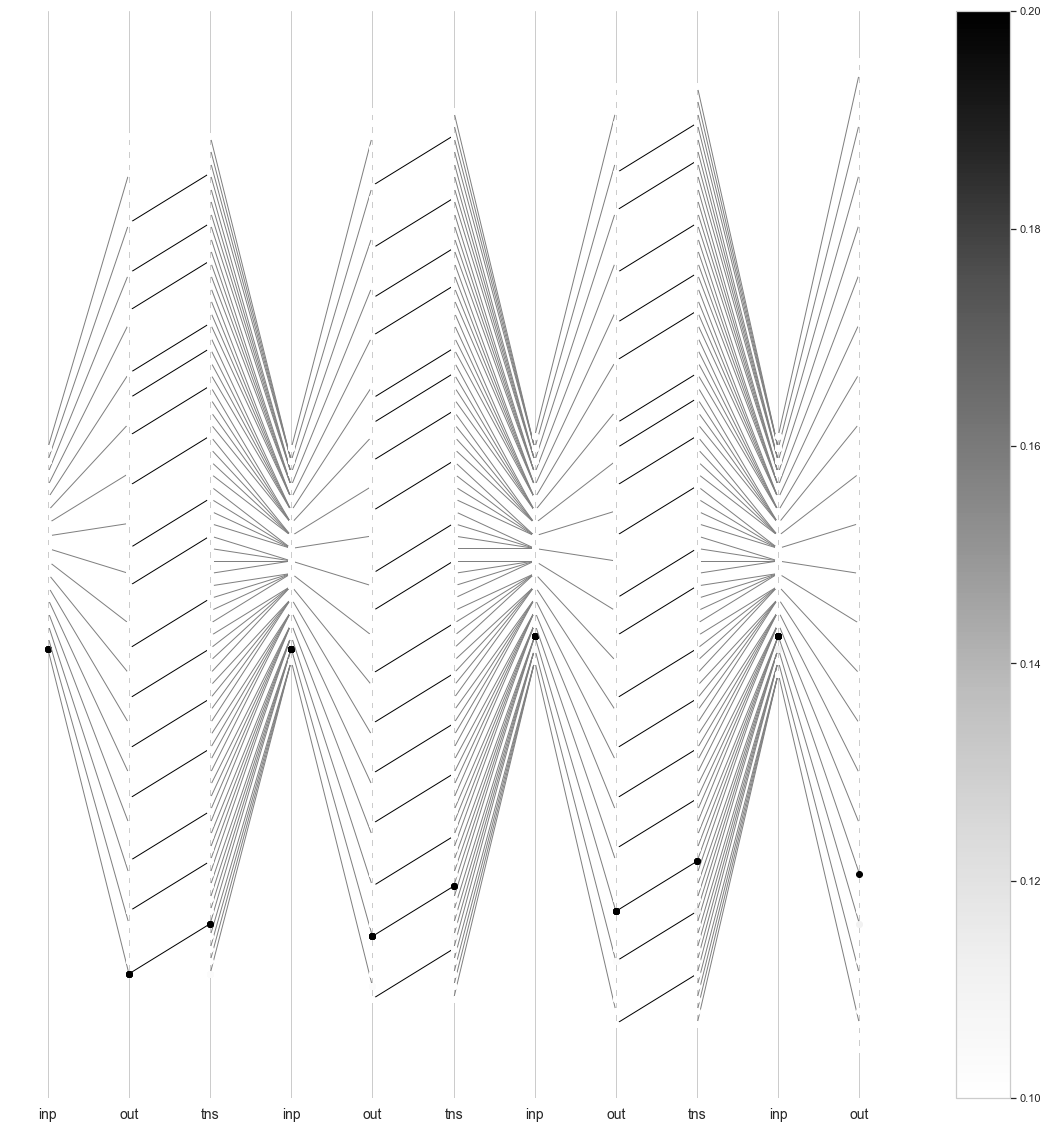

In [123]:
cc_ids_object.make_edges_dataframe()
cc_ids_object.draw_trellis(stages = [0,10], figsize = (20,20), \
                           include_forward_vals=True, fontsize = 14,edge_range=[0.1,0.2],state_range = [0.01,0.3])

We can further prune the posterior trellis and keep only the important paths, ignoring the rest.

Drawing trellis.: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.21it/s]


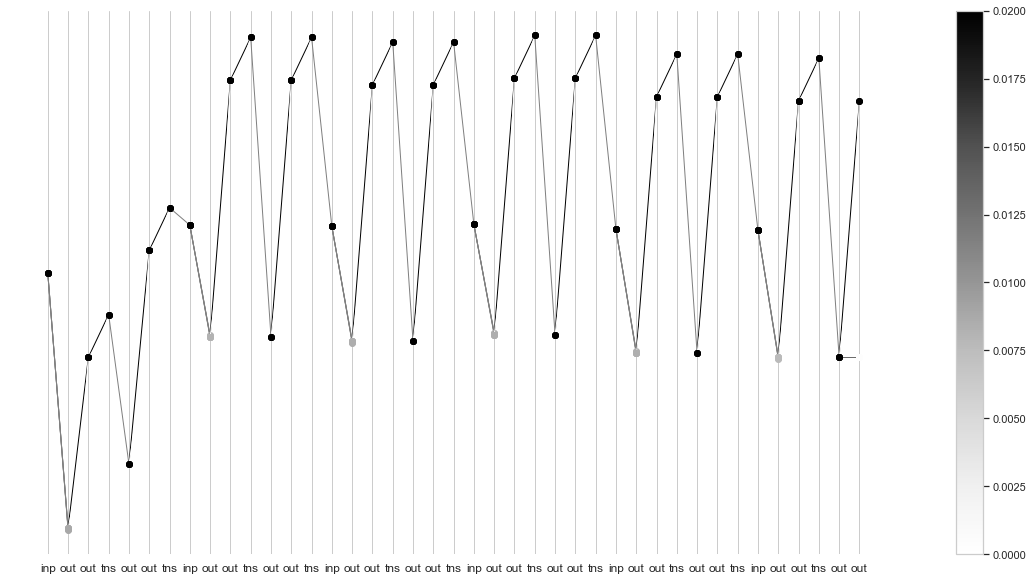

In [56]:
cc_ids_object.make_edges_dataframe()
cc_ids_object.draw_optimal_path(stages = [0,40], figsize = (20,10), fontsize = 12,\
                           edge_range=[0,0.02], state_range = [0.05,0.5], cmap = cm.Greys)

#### Viterbi

Viterbi decoding in the IDS trellis. Notice that Viterbi doesn't give you the most likely input sequence, instead it gives the most likely sequence of states (multiple sequence of states can correspond to the same input sequence).

As for BCJR, the first call takes time to run due to just in time compilation, subsequent calls should be faster.

In [58]:
enc_init_state = cc.trellis_states[0][0]       # encoder initial state
enc_end_state = cc.trellis_states[-1][0]       # encoder end state
in_hat = cc_ids_object.viterbi(tr_list, enc_init_state, enc_end_state)

In [59]:
in_hat == in_seq

array([ True,  True,  True,  True,  True,  True, False, False, False,
        True])

Drawing trellis.: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:34<00:00,  1.14it/s]


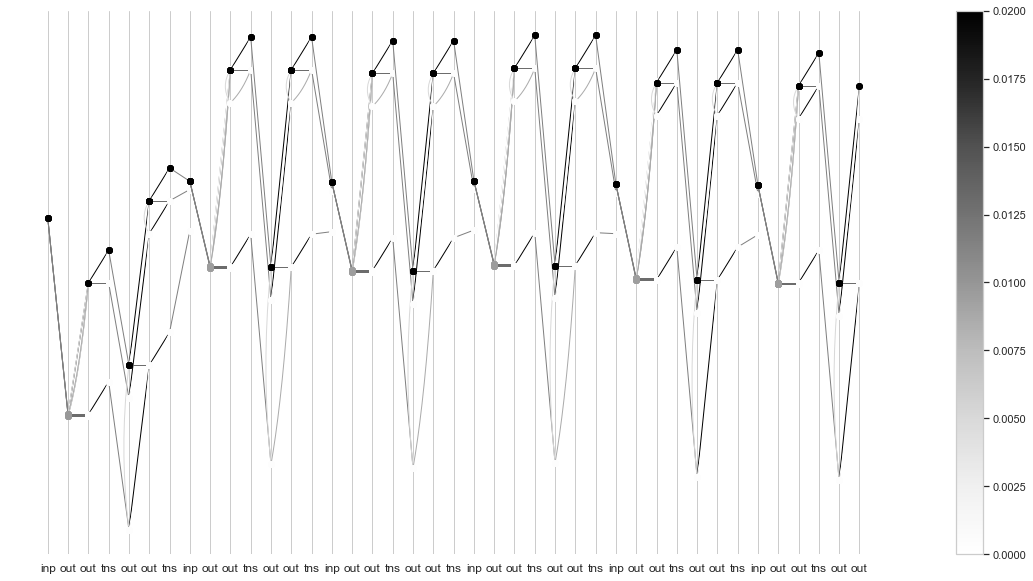

In [60]:
cc_ids_object.make_edges_dataframe()
cc_ids_object.draw_optimal_path(stages = [0,40], figsize = (20,10), fontsize = 12,\
                           edge_range=[0,0.02], state_range = [0.005,0.5], cmap = cm.Greys)

# Trellis BMA

In this part, we see how to use trellis BMA to decode using multiple traces.

**NOTE:** Trellis BMA, with the current implementation can only be used for EVEN length inputs.

In [61]:
from trellis_bma import *

We first construct the code and create the ids trellis object, which is the input to the trellis bma algo. 

In [65]:
in_len = 100              # Even input length
N_cw = 110                # set codeword length
redundancy = N_cw-in_len

A_in = 4
A_cw = 4

# make code trellis

cc = conv_code()
G = np.array([[1],[1]])
cc.quar_cc(G)
cc.make_trellis(in_len)
cc.puncture(redundancy=redundancy)
cc.add_coset()
cc.make_encoder()


# make ids trellis with 1 trace

code_trellis_states = cc.trellis_states
code_trellis_edges = cc.trellis_edges
code_time_type = cc.time_type

num_traces = 1
p_del = 0.02
p_sub = 0.03
p_ins = 0.02
max_drift = 15

ids_trellis = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
                 num_traces, p_del, p_sub, p_ins, max_drift, input_prior = None)

Creating trellis edges.: 100%|███████████████████████████████████████████████████████| 211/211 [00:09<00:00, 23.42it/s]


In [66]:
# generate input sequence, codeword and traces

in_seq = np.random.choice(4,size = in_len)
coded_seq = cc.encode(in_seq)

cluster_size = 4

tr_list = []
for j in range(cluster_size):
    tr_list.append(ids_trellis.simulate_ids(coded_seq))

We first attempt estimation with BMALA improved, and with 4 traces.

In [69]:
bma_estimate = bmala_imp(N_cw,tr_list,2)

In [68]:
bma_estimate == coded_seq

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### Trellis BMA without lookahead

Sequentially estimates the input sequence on-the-fly from the forward values for the first half, and the backward values for the second hald. Updates forward values based on the estimated symbol.

Apart from the trellis object and the traces, the algorithm needs the following as inputs:

- Encoder initial state (takes only one state as input)
- List of possible encoder end states

As with every other algorithm, first call takes time to run due to just-in-time compilation.

In [73]:
Tbma_noLA_estimate = trellis_bma(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                         cc.trellis_states[-1],lookahead = False)

In [72]:
in_seq == Tbma_noLA_estimate

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True, False, False,  True, False, False,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

### Trellis BMA with lookahead

Sequentially estimates the input sequence using both the forward and the backward values. Updates forward values for the first half based on the estimated symbol, and updates backward values for the second half.

Apart from the trellis object and the traces, the algorithm needs the following as inputs:

- Encoder initial state (takes only one state as input)
- List of possible encoder end states

As with every other algorithm, first call takes time to run due to just-in-time compilation.

In [76]:
Tbma_LA_estimate = trellis_bma(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                         cc.trellis_states[-1],lookahead = True)

In [75]:
in_seq == Tbma_LA_estimate

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])